In [100]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
%matplotlib inline

# Stages of Growth

Do we see distinct changes on each tile in terms of _stages_ (Transferring from creating objects to editing objects)

In [101]:
study_tiles = json.loads(open('study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


In [102]:
for idx,tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban, Philippines
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London, UK
8 Manhattan, NY


In [103]:
study_tiles = [study_tiles[i] for i in [0,2,4,1,6,7]]

In [104]:
for idx,tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Tacloban, Philippines
2 Monrovia, Liberia
3 Trisuli Bazar, Nepal
4 Heidelberg, Germany
5 London, UK


In [105]:
NROWS = 3
NCOLS = 2
FIGSIZE = (15,25)
WSPACE=0.3
HSPACE=0.4
sns.set(font_scale=1.25)

In [106]:
#Create the engine for Pandas to query SQL with
engine = create_engine('postgresql://anderstj@127.0.0.1:5432/osm-quality-full')

In [107]:
def get_full_quadkey_df(tile):
    df = pd.read_sql_query("SELECT * FROM tiles_per_year WHERE quadkey = '%s' order by year"%(tile['quad']),con=engine)
    df['name'] = tile['name']
    return df
x = get_full_quadkey_df(study_tiles[-1])

In [108]:
x.tail(3)

,id,quadkey,year,new_road_km,new_buildings,new_amenities,new_objects,edited_road_km,edited_buildings,edited_amenities,edited_objects,users_new_obj,users_edited_obj,name
10,33747641,031313131103,2014,28.35190,1052,134,2371,220.742,657,207,2971,77,130,"London, UK"
11,43263457,031313131103,2015,22.05870,4271,549,8444,145.096,1862,382,4483,61,110,"London, UK"
12,49105987,031313131103,2016,8.91563,1492,155,3422,143.433,343,127,1930,70,87,"London, UK"


In [109]:
"""
    Helper functions for annual and cumulative sums
"""
def get_annual_percentage_of_new_edits(row):
#     print(row)
    if row['edited_objects'] > 0 or row['new_objects']>0:
        return row['new_objects']/(row['edited_objects']+row['new_objects'])
    else:
        return 0
    
def get_annual_percentage_of_edited_objects(row):
#     print(row)
    if row['edited_objects'] > 0 or row['new_objects']>0:
        return row['edited_objects']/(row['edited_objects']+row['new_objects'])
    else:
        return 0

In [110]:
for tile in study_tiles:
    tile['df'] = get_full_quadkey_df(tile)

## Edited Objects Overtime

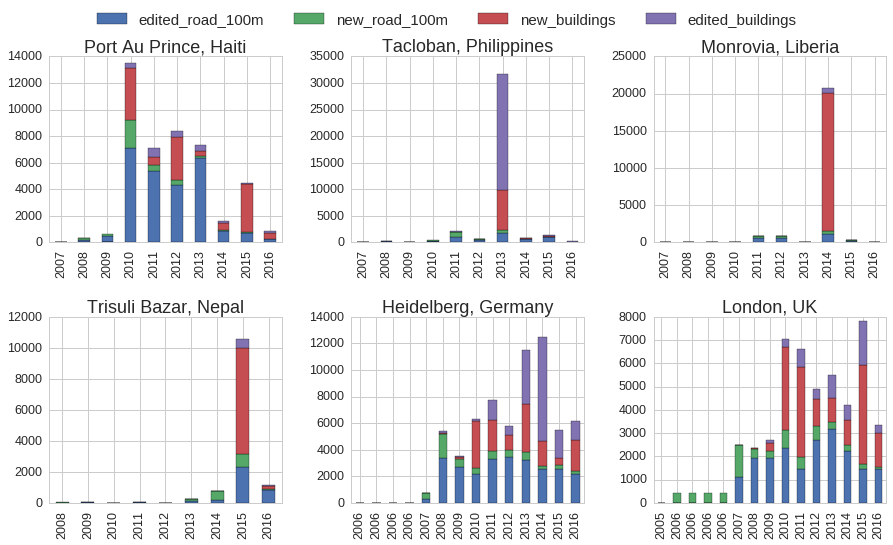

In [111]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    df = tile['df']
    
    roads = df[['new_road_km','edited_road_km','year']].copy()
#     roads.plot(ax=ax, kind='bar', stacked=True)

    roads['new_road_100m'] = roads.new_road_km*10
    roads['edited_road_100m'] = roads.edited_road_km*10
  
    
    #BUILDINGS

    buildings = df[['new_buildings','edited_buildings','year']].copy()
#     buildings.plot(ax=ax, kind='bar', stacked=True, x='year')
    
#     buildings['percent_new']    = buildings.new_buildings / (buildings.new_buildings + buildings.edited_buildings)
#     buildings['percent_edited'] = buildings.edited_buildings / (buildings.new_buildings + buildings.edited_buildings)
#     buildings[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')
    
    
    #OKAY, NOW FOR SOMETHING REALLY CRAZY... CAN WE DO IT ALL STACKED?
    
    total_roads_and_buildings = roads[['edited_road_100m','new_road_100m','year']].merge(buildings, on='year')

    total_roads_and_buildings.plot(ax=ax,kind='bar',stacked=True,x='year')
    
    #     ax.set_xticklabels(df.year)
    
    ax.legend_.remove()
    ax.set_xlabel('')
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=15)
None

## Analysis

We see very different stages of growth between tiles where disaster mapping has clearly occured and tiles where there are active communities.

More importantly, each of the HOT activations called for different objects to be mapped: _buildings_ or _roads_, as is evidenced by the difference between Haiti (2010) and Tacloban or Nepal. Note also, that buildings were edited more than added in Tacloban - there was a lot of damage assessment work being done with these data.


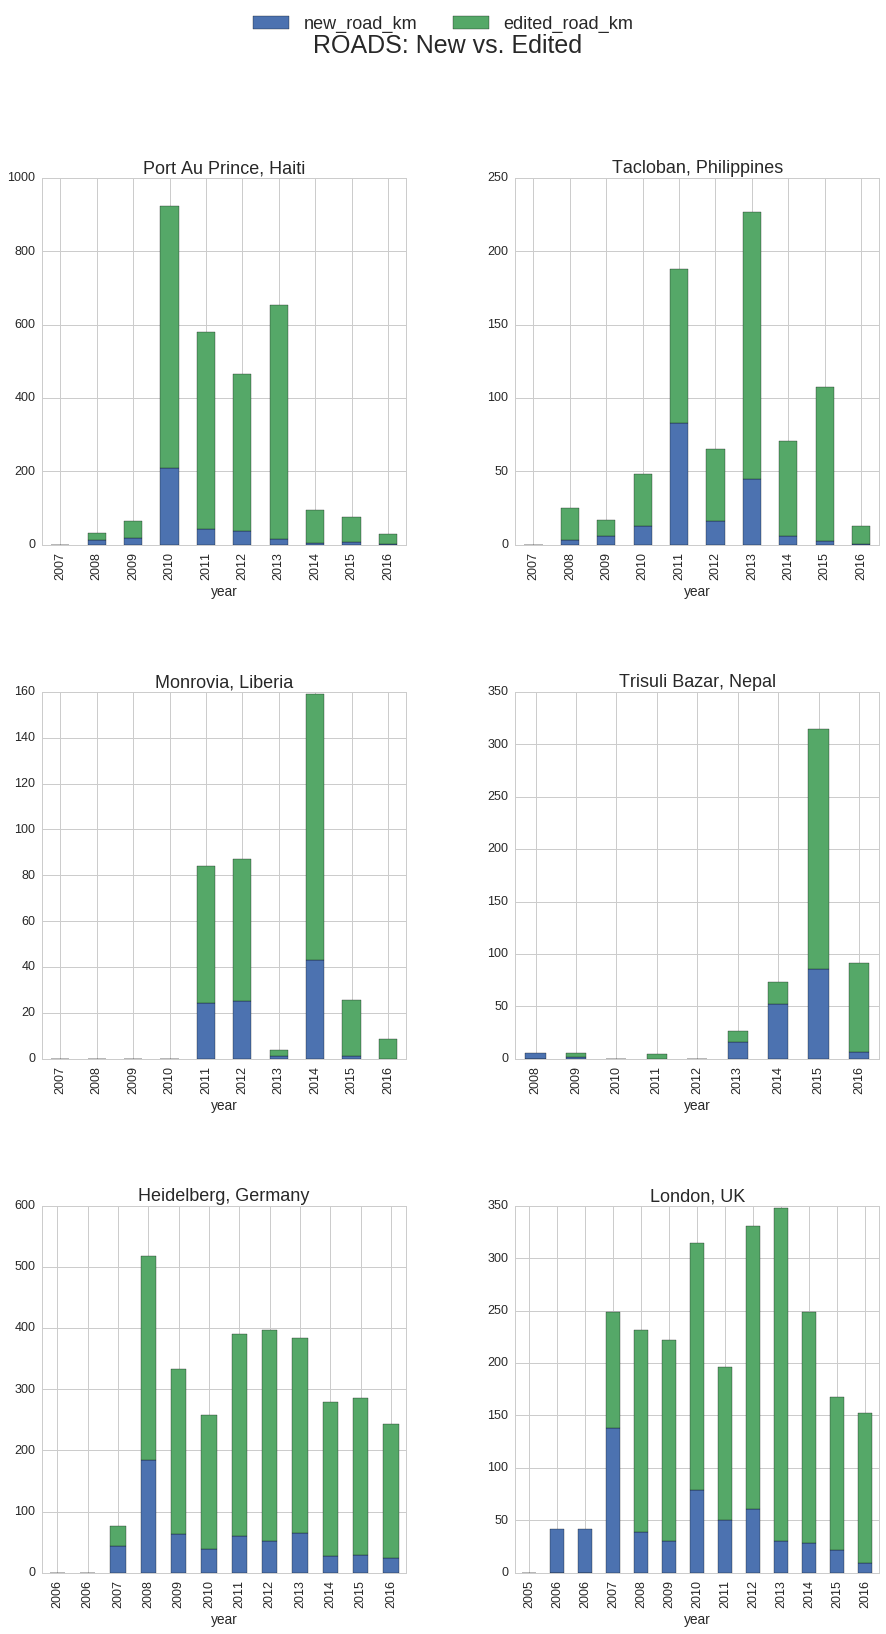

In [112]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    roads.plot(ax=ax, kind='bar', stacked=True, x='year')
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("ROADS: New vs. Edited",fontsize=25)

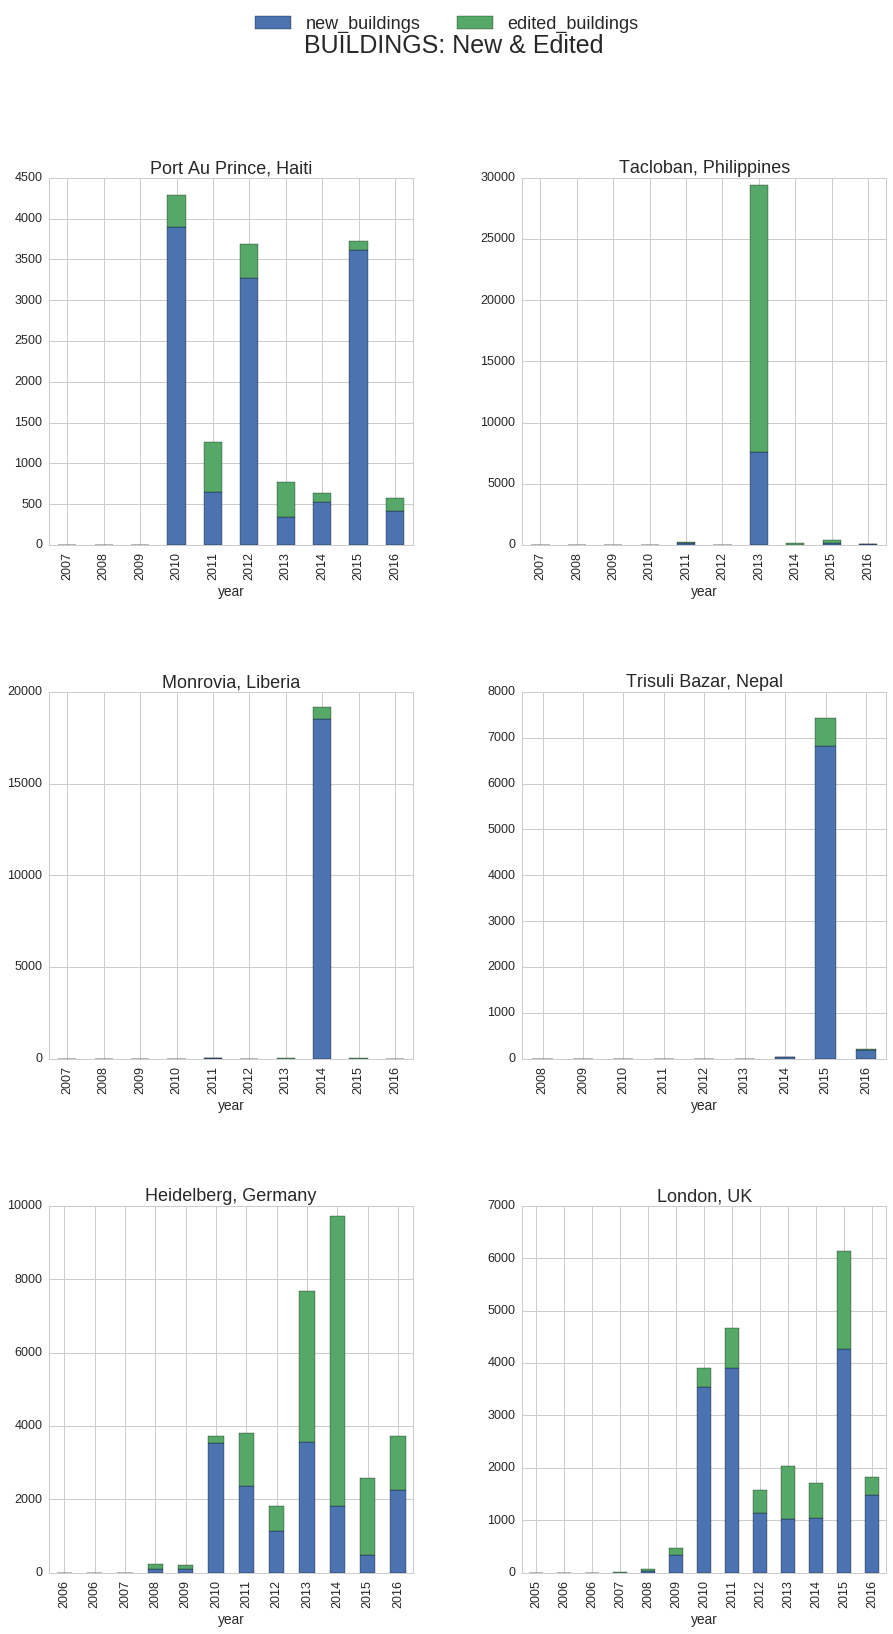

In [113]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    #BUILDINGS
    buildings =  tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings.plot(ax=ax, kind='bar', stacked=True, x='year')
            
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("BUILDINGS: New & Edited",fontsize=25)

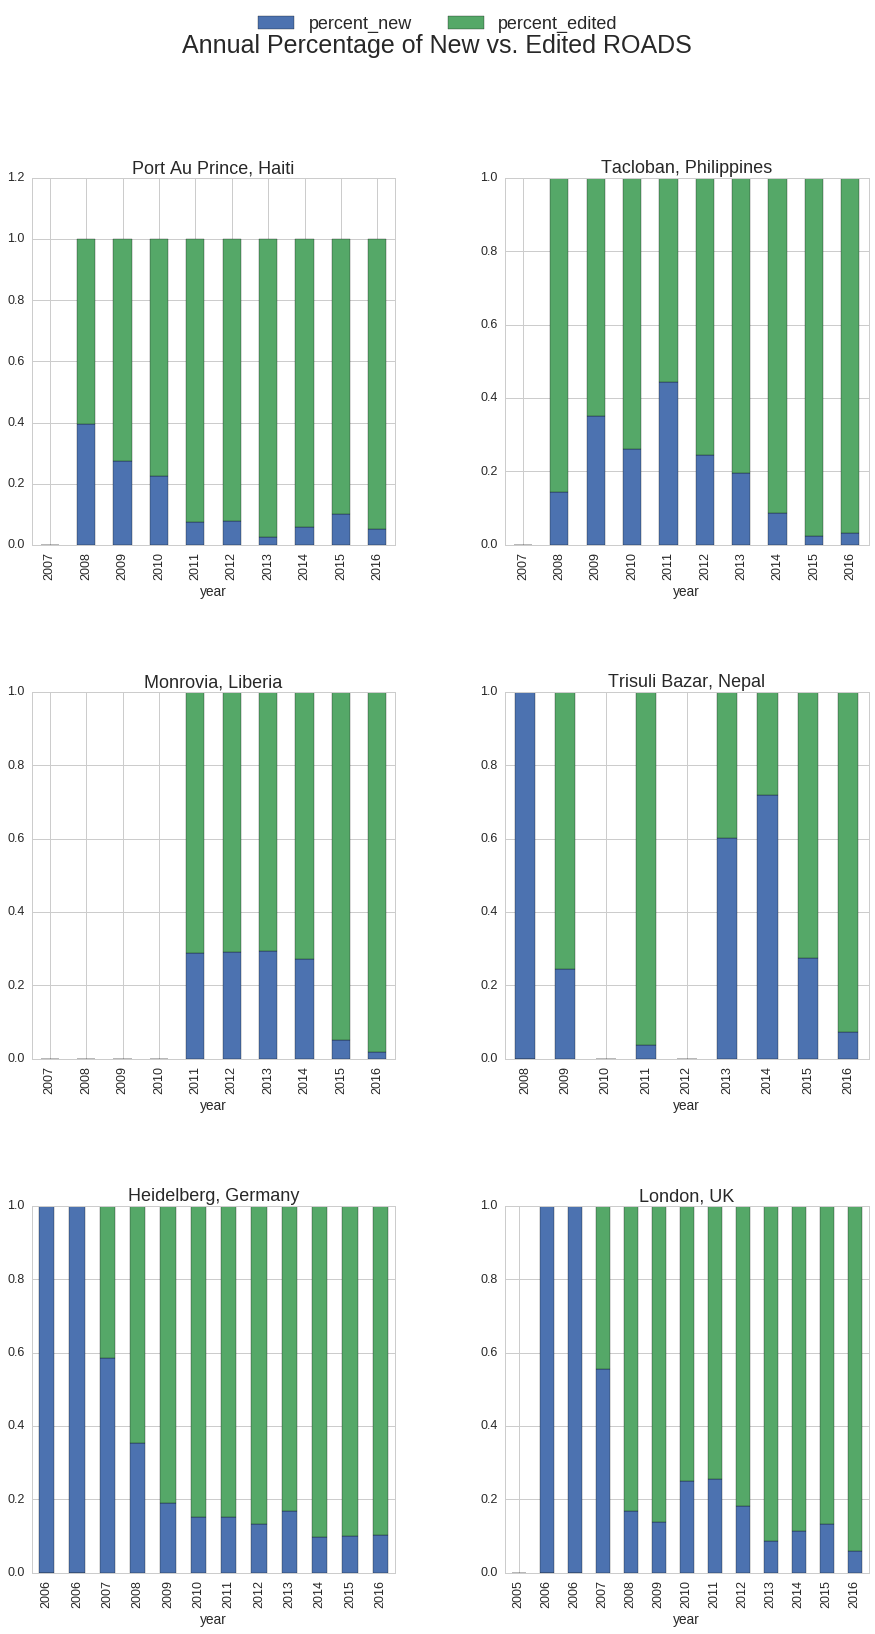

In [114]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
  
    roads['percent_new'] = roads.new_road_km / (roads.new_road_km + roads.edited_road_km)
    roads['percent_edited'] = roads.edited_road_km / (roads.new_road_km + roads.edited_road_km)
    roads[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')

    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("Annual Percentage of New vs. Edited ROADS", fontsize=25)

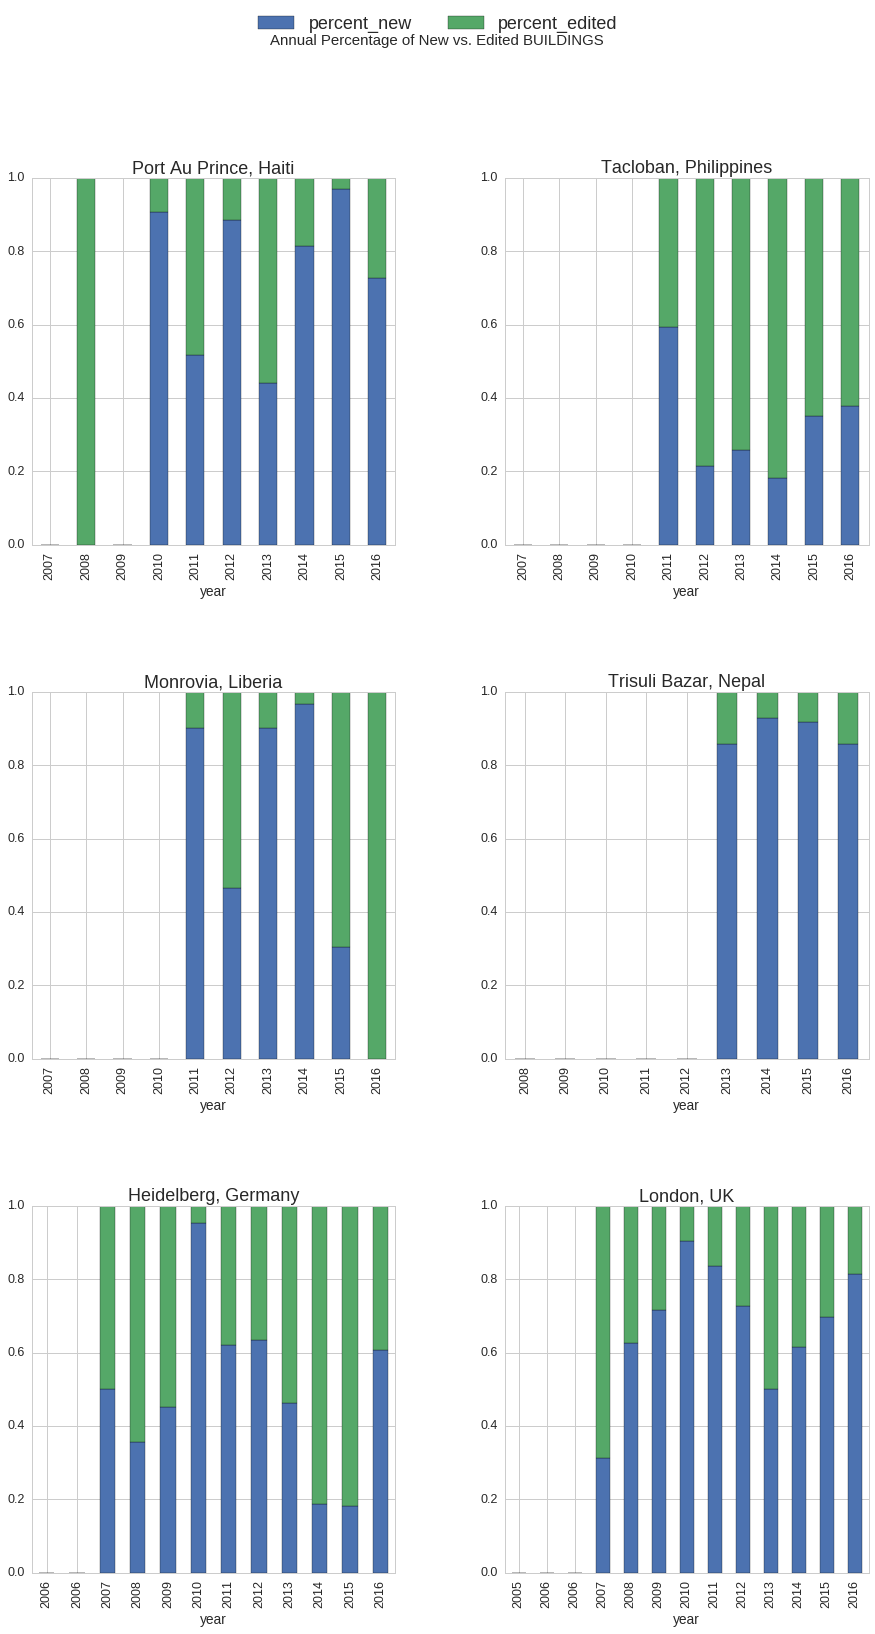

In [115]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    #BUILDINGS
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings['percent_new']    = buildings.new_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings['percent_edited'] = buildings.edited_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("Annual Percentage of New vs. Edited BUILDINGS")

<br>
<br>
<hr>
## Calculate similar tiles

In [116]:
def get_sim_tiles_average(study_tile):
    tmp_df = pd.DataFrame()
    for t in study_tile['compare_tiles']:
        tmp_df = pd.concat([tmp_df, t['df']],ignore_index=True)
    avg_df = tmp_df.groupby('year').aggregate({'new_road_km':pd.Series.mean,
                                  'new_buildings':pd.Series.mean,
                                  'new_objects': pd.Series.mean,
                                  'edited_road_km':pd.Series.mean,
                                  'edited_buildings':pd.Series.mean,
                                  'edited_amenities':pd.Series.mean,
                                  'edited_objects': pd.Series.mean,
                                  'users_new_obj':pd.Series.mean,
                                  'users_edited_obj':pd.Series.mean})
    avg_df['name'] = "avg_compare-" + study_tile['name']
    return avg_df

In [117]:
for tile in study_tiles:
    for t in tile['compare_tiles']:
        t['name'] = "compare-" + tile['name']
        t['df'] = get_full_quadkey_df(t)
    tile['compare_avg'] = get_sim_tiles_average(tile)

<br>
<br>
<hr>
# Compare Study Tiles to Similar Tiles

## 1. Roads

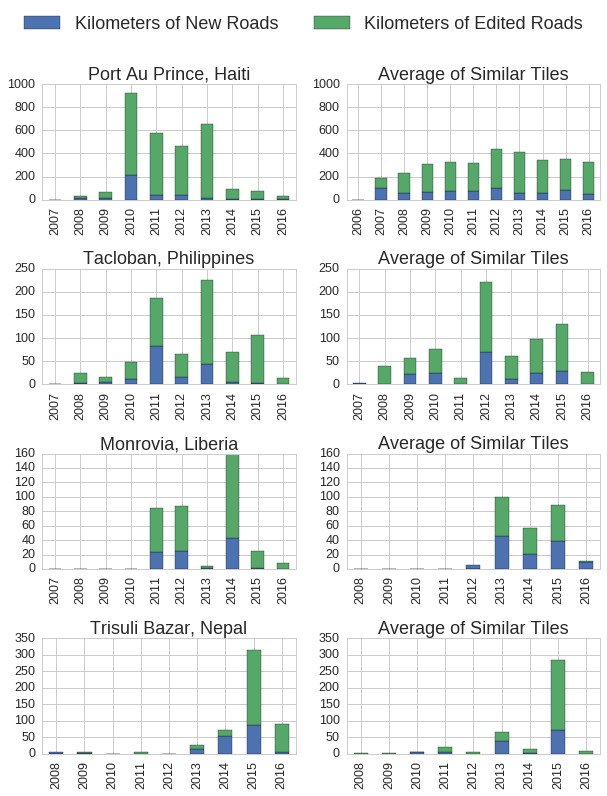

In [118]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[:4]):
    
    this_row = axs[idx]
    this_row[0].set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    roads.plot(ax=this_row[0], kind='bar', stacked=True, x='year')
    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=18)
    compare_roads = tile['compare_avg'][['new_road_km','edited_road_km']].copy()
    compare_roads.plot(ax=this_row[1], kind='bar', stacked=True)
    
    this_row[1].set_ylim(this_row[0].get_ylim())
    
    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")
    
    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,("Kilometers of New Roads", "Kilometers of Edited Roads"),
              loc = ('upper center'), ncol=2, fontsize=18)

## 2. Buildings

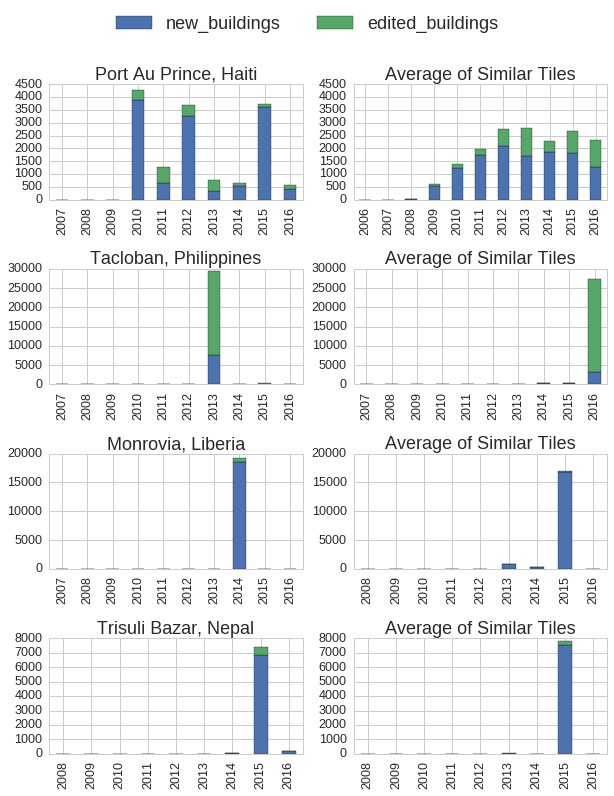

In [119]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[:4]):
    
    this_row = axs[idx]
    this_row[0].set_title(tile['name'], fontsize=18)
    
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings.plot(ax=this_row[0], kind='bar', stacked=True, x='year')
    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=18)
    compare_buildings = tile['compare_avg'][['new_buildings','edited_buildings']].copy()
    compare_buildings.plot(ax=this_row[1], kind='bar', stacked=True)
    

    this_row[1].set_ylim(this_row[0].get_ylim())
    
    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")

    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,labels,#("New Buildings", "Edited Buildings"),
              loc = ('upper center'), ncol=2, fontsize=18)

## 3. Annual Percentage of New Roads / Edited Roads

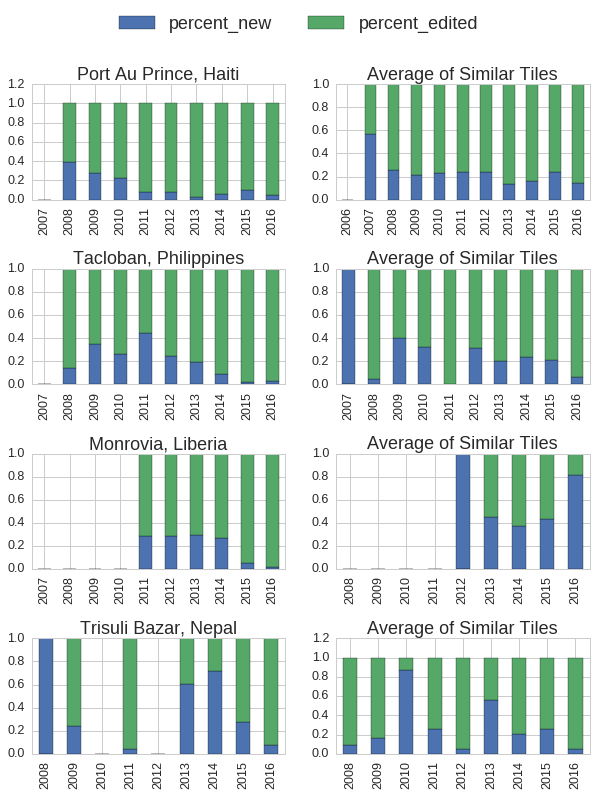

In [120]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[:4]):
    
    this_row = axs[idx]
    this_row[0].set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    
    roads['percent_new'] = roads.new_road_km / (roads.new_road_km + roads.edited_road_km)
    roads['percent_edited'] = roads.edited_road_km / (roads.new_road_km + roads.edited_road_km)
    roads[['percent_new','percent_edited','year']].plot(ax=this_row[0], kind='bar', stacked=True, x='year')
    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=18)
    compare_roads = tile['compare_avg'][['new_road_km','edited_road_km']].copy()

    compare_roads['percent_new'] = compare_roads.new_road_km / (compare_roads.new_road_km + compare_roads.edited_road_km)
    compare_roads['percent_edited'] = compare_roads.edited_road_km / (compare_roads.new_road_km + compare_roads.edited_road_km)
    compare_roads[['percent_new','percent_edited']].plot(ax=this_row[1], kind='bar', stacked=True)
        
    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")
    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,labels,#("Percent New Roads", "Percent Edited Roads"),
              loc = ('upper center'), ncol=2, fontsize=18)

## 4. Annual Percentage of New / Edited Buildings

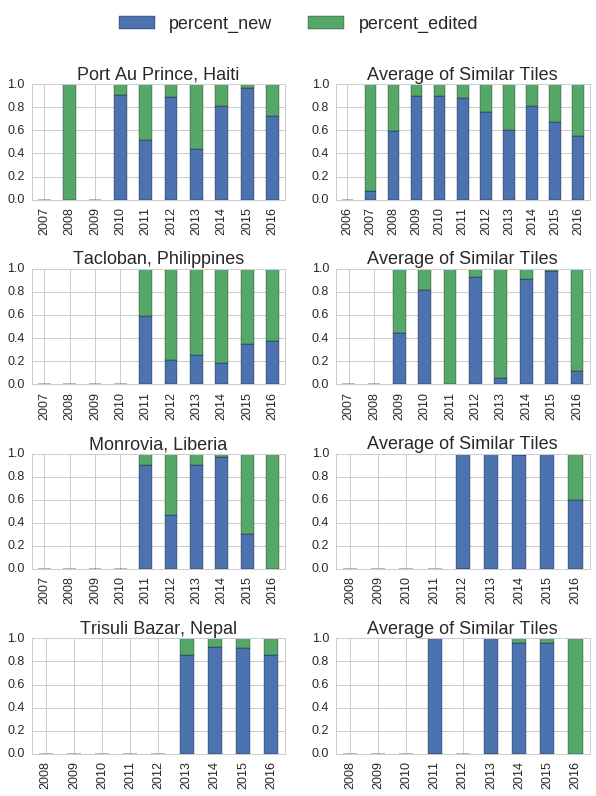

In [121]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[:4]):
    
    this_row = axs[idx]
    this_row[0].set_title(tile['name'], fontsize=18)
    
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings['percent_new']    = buildings.new_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings['percent_edited'] = buildings.edited_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings[['percent_new','percent_edited','year']].plot(ax=this_row[0], kind='bar', stacked=True, x='year')

    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=18)
    
    compare_buildings = tile['compare_avg'][['new_buildings','edited_buildings']].copy()
    compare_buildings['percent_new']    = compare_buildings.new_buildings / (compare_buildings.new_buildings + compare_buildings.edited_buildings)
    compare_buildings['percent_edited'] = compare_buildings.edited_buildings / (compare_buildings.new_buildings + compare_buildings.edited_buildings)
    compare_buildings[['percent_new','percent_edited']].plot(ax=this_row[1], kind='bar', stacked=True)

    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")
    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,labels,#("Percent New Buildings", "Percent Edited Buildings"),
              loc = ('upper center'), ncol=2, fontsize=18)

## 5. Can it all be put together?

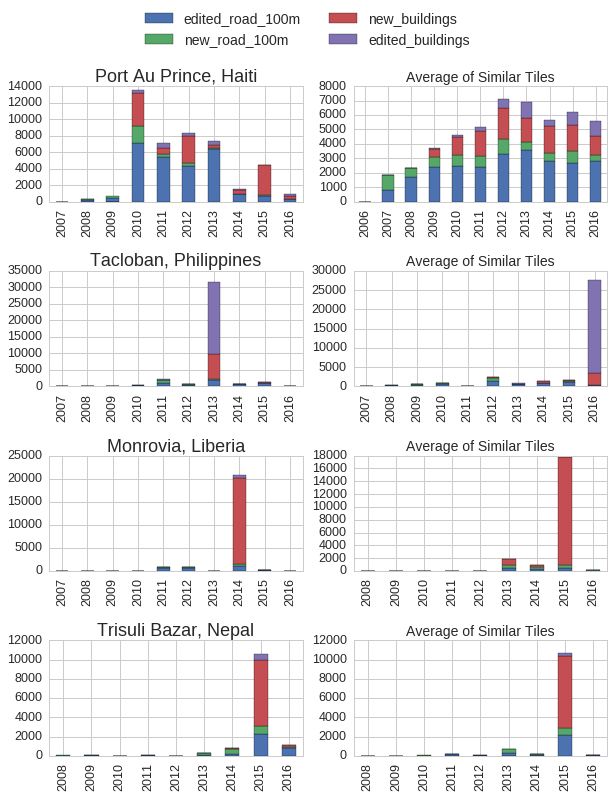

In [134]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[:4]):
    
    this_row=axs[idx]
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    roads['new_road_100m'] = roads.new_road_km*10
    roads['edited_road_100m'] = roads.edited_road_km*10
    
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    
    total_roads_and_buildings = roads[['edited_road_100m','new_road_100m','year']].merge(buildings, on='year')
    total_roads_and_buildings.plot(ax=this_row[0],kind='bar',stacked=True,x='year')

    this_row[0].set_title(tile['name'], fontsize=18)
    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=14)
    
    tile['compare_avg']['year'] = tile['compare_avg'].index.values

    compare_roads = tile['compare_avg'][['new_road_km','edited_road_km','year']].copy()
    compare_roads['new_road_100m'] = compare_roads.new_road_km*10
    compare_roads['edited_road_100m'] = compare_roads.edited_road_km*10
    
    compare_buildings = tile['compare_avg'][['new_buildings','edited_buildings','year']].copy()
    
    compare_total_roads_and_buildings = compare_roads[['edited_road_100m','new_road_100m','year']].merge(compare_buildings, on='year')
    compare_total_roads_and_buildings.plot(ax=this_row[1],kind='bar',stacked=True,x='year')

    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")
    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=2, fontsize=14)
None

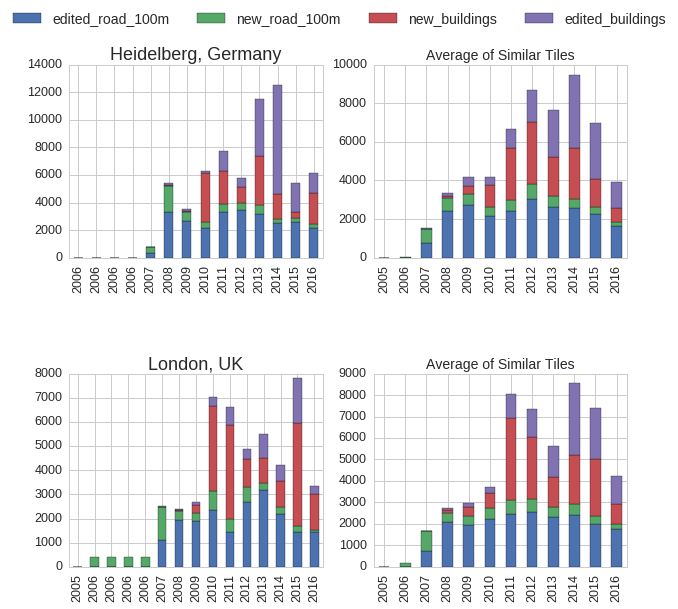

In [135]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,9), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for idx, tile in enumerate(study_tiles[4:6]):
    
    this_row=axs[idx]
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    roads['new_road_100m'] = roads.new_road_km*10
    roads['edited_road_100m'] = roads.edited_road_km*10
    
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    
    total_roads_and_buildings = roads[['edited_road_100m','new_road_100m','year']].merge(buildings, on='year')
    total_roads_and_buildings.plot(ax=this_row[0],kind='bar',stacked=True,x='year')

    this_row[0].set_title(tile['name'], fontsize=18)
    
    #Now create compare tiles:
    this_row[1].set_title("Average of Similar Tiles",fontsize=14)
    
    tile['compare_avg']['year'] = tile['compare_avg'].index.values

    compare_roads = tile['compare_avg'][['new_road_km','edited_road_km','year']].copy()
    compare_roads['new_road_100m'] = compare_roads.new_road_km*10
    compare_roads['edited_road_100m'] = compare_roads.edited_road_km*10
    
    compare_buildings = tile['compare_avg'][['new_buildings','edited_buildings','year']].copy()
    
    compare_total_roads_and_buildings = compare_roads[['edited_road_100m','new_road_100m','year']].merge(compare_buildings, on='year')
    compare_total_roads_and_buildings.plot(ax=this_row[1],kind='bar',stacked=True,x='year')

    for ax in this_row:
        ax.legend_.remove()
        ax.set_xlabel("")
    handles, labels = this_row[1].get_legend_handles_labels()

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=14)
None